## Timeseries clustering

Time series clustering is to partition time series data into groups based on similarity or distance, so that time series in the same cluster are similar.

Methodology followed:
* Use Variational Recurrent AutoEncoder (VRAE) for dimensionality reduction of the timeseries
* To visualize the clusters, PCA and t-sne are used

Paper:
https://arxiv.org/pdf/1412.6581.pdf

#### Contents

0. [Load data and preprocess](#Load-data-and-preprocess)
1. [Initialize VRAE object](#Initialize-VRAE-object)
2. [Fit the model onto dataset](#Fit-the-model-onto-dataset)
3. [Transform the input timeseries to encoded latent vectors](#Transform-the-input-timeseries-to-encoded-latent-vectors)
4. [Save the model to be fetched later](#Save-the-model-to-be-fetched-later)
5. [Visualize using PCA and tSNE](#Visualize-using-PCA-and-tSNE)

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

### Import required modules

In [2]:
from vrae.vrae import VRAE
from vrae.utils import *
import numpy as np
import torch

#import plotly
from torch.utils.data import DataLoader, TensorDataset
#plotly.offline.init_notebook_mode()

### Input parameters

In [3]:
dload = './model_dir' #download directory

### Hyper parameters

In [4]:
hidden_size = 90
hidden_layer_depth = 1
latent_length = 20
batch_size = 1
learning_rate = 0.0005
n_epochs = 40
dropout_rate = 0.2
optimizer = 'Adam' # options: ADAM, SGD
cuda = True # options: True, False
print_every=30
clip = True # options: True, False
max_grad_norm=5
loss = 'MSELoss' # options: SmoothL1Loss, MSELoss
block = 'LSTM' # options: LSTM, GRU

### Load data and preprocess

In [5]:
X_train, X_val, y_train, y_val = open_data('data', ratio_train=0.9)

num_classes = len(np.unique(y_train))
base = np.min(y_train)  # Check if data is 0-based
if base != 0:
    y_train -= base
y_val -= base

In [6]:
train_dataset = TensorDataset(torch.from_numpy(X_train))
test_dataset = TensorDataset(torch.from_numpy(X_val))

**Fetch `sequence_length` from dataset**

In [7]:
sequence_length = X_train.shape[1]
print(sequence_length)
print(X_train.shape)
#So, shape is
# (Nsamples, timesteps, nfeatures)

140
(8549, 140, 1)


**Fetch `number_of_features` from dataset**

This config corresponds to number of input features

In [8]:
number_of_features = X_train.shape[2]

### Initialize VRAE object

VRAE inherits from `sklearn.base.BaseEstimator` and overrides `fit`, `transform` and `fit_transform` functions, similar to sklearn modules

In [9]:
vrae = VRAE(sequence_length=sequence_length,
            number_of_features = number_of_features,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate,
            optimizer = optimizer, 
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            loss = loss,
            block = block,
            dload = dload)

/homedtic/gmarti/project/anaconda3/envs/dlnn2/lib/python3.6/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/homedtic/gmarti/project/anaconda3/envs/dlnn2/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


### Fit the model onto dataset

In [10]:
vrae.fit(train_dataset)

#If the model has to be saved, with the learnt parameters use:
# vrae.fit(dataset, save = True)

Epoch: 0
Batch 30, loss = 4288.9761, recon_loss = 4288.9336, kl_loss = 0.0427
Batch 60, loss = 2630.7402, recon_loss = 2627.3994, kl_loss = 3.3408
Batch 90, loss = 2788.2925, recon_loss = 2784.6389, kl_loss = 3.6536
Batch 120, loss = 2566.3467, recon_loss = 2562.9121, kl_loss = 3.4346
Batch 150, loss = 2617.5989, recon_loss = 2614.5833, kl_loss = 3.0157
Batch 180, loss = 2798.7788, recon_loss = 2796.5205, kl_loss = 2.2583
Batch 210, loss = 2306.7722, recon_loss = 2304.3550, kl_loss = 2.4173
Batch 240, loss = 2577.2769, recon_loss = 2575.1824, kl_loss = 2.0945
Average loss: 2907.2649
Epoch: 1
Batch 30, loss = 2576.5151, recon_loss = 2574.1802, kl_loss = 2.3349
Batch 60, loss = 2619.7419, recon_loss = 2617.3433, kl_loss = 2.3988
Batch 90, loss = 2213.2881, recon_loss = 2210.8130, kl_loss = 2.4751
Batch 120, loss = 2058.0625, recon_loss = 2055.6042, kl_loss = 2.4581
Batch 150, loss = 2404.0837, recon_loss = 2401.8105, kl_loss = 2.2732
Batch 180, loss = 2200.9875, recon_loss = 2198.5400, k

(40,)
(140, 928, 1)


NameError: name 'mean_absolute_error' is not defined

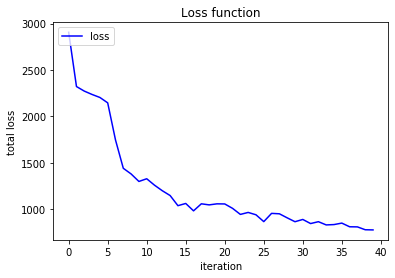

In [12]:
## Plot  the loss function
%matplotlib inline
# Plotting loss
# Get full curve from losss

import matplotlib.pyplot as plt

loss_curve = vrae.training_loss
print(np.array(loss_curve).shape)
#Plot it
plt.plot(range(len(loss_curve)), loss_curve, '-b', label='loss')

plt.xlabel("iteration")
plt.ylabel("total loss")

plt.legend(loc='upper left')
plt.title("Loss function")

# Transform the test dataset
x_hat = vrae.reconstruct(test_dataset)

print(x_hat.shape)

#Compute mean absolute error
mse_test = mean_absolute_error(test_dataset, x_hat)
print('MSE over the test set: ' + str(mse_test))

### Transform the input timeseries to encoded latent vectors

In [13]:
z_run = vrae.transform(test_dataset)

#If the latent vectors have to be saved, pass the parameter `save`
# z_run = vrae.transform(dataset, save = True)

### Save the model to be fetched later

In [14]:
vrae.save('vrae.pth')

# To load a presaved model, execute:
# vrae.load('vrae.pth')

### Visualize using PCA and tSNE

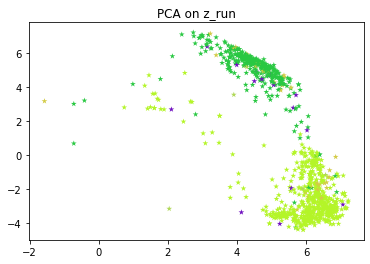

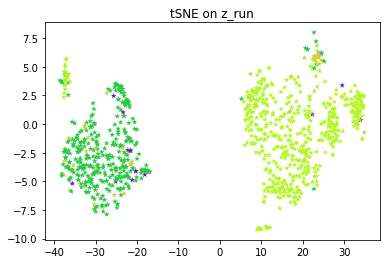

In [15]:
plot_clustering(z_run, y_val, engine='matplotlib', download = False)

# If plotly to be used as rendering engine, uncomment below line
#plot_clustering(z_run, y_val, engine='plotly', download = False)